
[Step 1] 객체 분리 중 (BiRefNet)...

[Step 2] 고퀄리티 배경 생성 중 (Juggernaut XL)...


100%|██████████| 35/35 [00:13<00:00,  2.59it/s]
/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/diffusers/pipelines/stable_diffusion_xl/pipeline_stable_diffusion_xl.py:748: FutureWarning: `upcast_vae` is deprecated and will be removed in version 1.0.0. `upcast_vae` is deprecated. Please use `pipe.vae.to(torch.float32)`. For more details, please refer to: https://github.com/huggingface/diffusers/pull/12619#issue-3606633695.
  deprecate(



[Step 3] 이미지 합성 및 그림자 생성...

[Step 4] 전체 톤 매너 통합 (Img2Img)...


100%|██████████| 4/4 [00:01<00:00,  2.60it/s]
/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/diffusers/pipelines/stable_diffusion_xl/pipeline_stable_diffusion_xl_img2img.py:896: FutureWarning: `upcast_vae` is deprecated and will be removed in version 1.0.0. `upcast_vae` is deprecated. Please use `pipe.vae.to(torch.float32)`. For more details, please refer to: https://github.com/huggingface/diffusers/pull/12619#issue-3606633695.
  deprecate(



[Step 5] 광고 카피 합성...


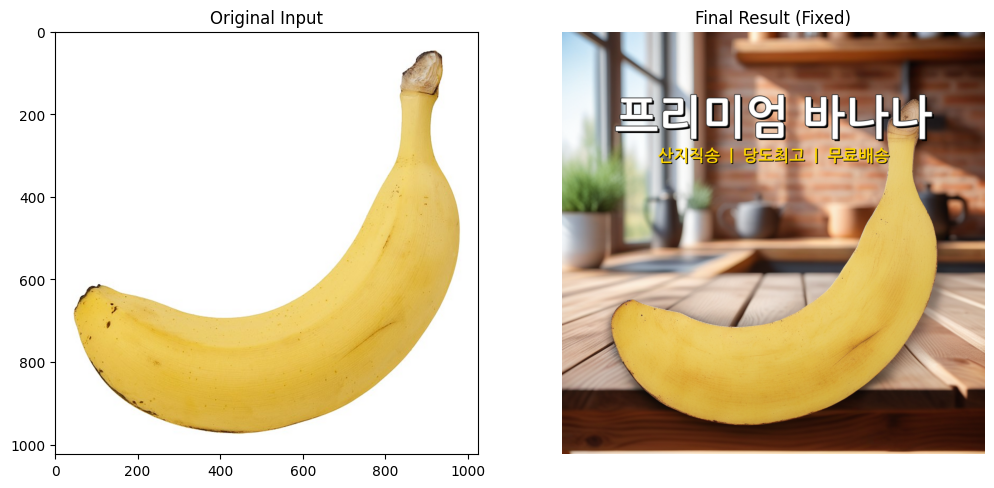

In [4]:
import torch
import gc
import os
import requests
import numpy as np
from PIL import Image, ImageDraw, ImageFont, ImageFilter, ImageOps
from torchvision import transforms
from transformers import AutoModelForImageSegmentation
from diffusers import AutoPipelineForText2Image, AutoPipelineForImage2Image
from diffusers.utils import load_image
import matplotlib.pyplot as plt

# ==========================================
# ⚙️ 설정 (최신 모델 적용)
# ==========================================
DEVICE = "cuda"
TORCH_DTYPE = torch.float16

# 퀄리티가 훨씬 뛰어난 파인튜닝 모델 (Juggernaut XL)
MODEL_ID = "RunDiffusion/Juggernaut-XL-v9" 

def flush():
    gc.collect()
    torch.cuda.empty_cache()

def download_font(font_name="NanumGothicBold.ttf"):
    url = "https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Bold.ttf"
    if not os.path.exists(font_name) or os.path.getsize(font_name) < 1000:
        r = requests.get(url)
        with open(font_name, 'wb') as f:
            f.write(r.content)
    return font_name

# ==========================================
# ✂️ STEP 1: 정밀 배경 제거 (BiRefNet - 유지)
# ==========================================
def extract_object(image_path):
    print("\n[Step 1] 객체 분리 중 (BiRefNet)...")
    birefnet = AutoModelForImageSegmentation.from_pretrained(
        "ZhengPeng7/BiRefNet", trust_remote_code=True
    )
    birefnet.to(DEVICE)
    birefnet.eval()

    img = load_image(image_path).convert("RGB")
    
    # 이미지 리사이즈 (SDXL 최적 해상도인 1024x1024 근처로 맞춤)
    img = img.resize((1024, 1024))
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    input_tensor = transform(img).unsqueeze(0).to(DEVICE)
    
    with torch.no_grad():
        preds = birefnet(input_tensor)[-1].sigmoid().cpu()
    
    pred = preds[0].squeeze()
    mask = transforms.ToPILImage()(pred).resize(img.size)
    mask = mask.point(lambda x: 255 if x > 128 else 0)
    
    foreground = img.copy()
    foreground.putalpha(mask)
    
    del birefnet, input_tensor
    flush()
    return img, foreground, mask

# ==========================================
# 🎨 STEP 2: 배경 새로 생성 (Text-to-Image)
# ==========================================
def generate_new_background():
    print("\n[Step 2] 고퀄리티 배경 생성 중 (Juggernaut XL)...")
    
    pipe = AutoPipelineForText2Image.from_pretrained(
        MODEL_ID,
        torch_dtype=TORCH_DTYPE,
        variant="fp16",
        use_safetensors=True
    ).to(DEVICE)
    
    # 제품 사진 전용 프롬프트 (테이블과 배경 분리 명시)
    prompt = (
        "Professional product photography, front view, "
        "empty rustic wooden table top surface, "
        "blurred warm sunny kitchen background with bokeh, "
        "soft natural lighting, high resolution, 8k, masterpiece"
    )
    
    negative_prompt = (
        "banana, fruit, food, messy, dark, ugly, deformed, noisy, "
        "text, watermark, low quality"
    )
    
    bg_image = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        width=1024,
        height=1024,
        num_inference_steps=35, # Juggernaut은 스텝 수가 적당해도 잘 나옴
        guidance_scale=7.0
    ).images[0]
    
    del pipe
    flush()
    return bg_image

# ==========================================
# 🌑 STEP 3: 그림자 및 합성 (위치 조정 포함)
# ==========================================
def composite_images(bg_img, fg_img, mask):
    print("\n[Step 3] 이미지 합성 및 그림자 생성...")
    
    # 1. 바나나 크기 및 위치 조정 (배경에 맞게 살짝 축소 및 중앙 배치)
    fg_w, fg_h = fg_img.size
    scale_factor = 0.85 # 바나나가 너무 꽉 차지 않게 85%로 축소
    new_w = int(fg_w * scale_factor)
    new_h = int(fg_h * scale_factor)
    
    fg_resized = fg_img.resize((new_w, new_h), Image.LANCZOS)
    mask_resized = mask.resize((new_w, new_h), Image.LANCZOS)
    
    # 중앙 정렬 좌표 계산
    bg_w, bg_h = bg_img.size
    paste_x = (bg_w - new_w) // 2
    paste_y = (bg_h - new_h) // 2 + 50 # 살짝 아래로 내려서 안정감 주기
    
    # 2. 그림자 생성
    shadow = Image.new("RGBA", (bg_w, bg_h), (0, 0, 0, 0))
    
    # 그림자용 마스크 배치
    shadow_canvas = Image.new("L", (bg_w, bg_h), 0)
    shadow_canvas.paste(mask_resized, (paste_x, paste_y))
    
    # 그림자 변형 (눕히기 및 블러)
    shadow_layer = shadow.copy()
    shadow_layer.paste((0,0,0,255), (0,0), mask=shadow_canvas)
    
    # 바닥에 닿는 느낌을 위해 Y축으로 살짝 이동 및 블러
    shadow_offset_y = 20
    shadow_offset_x = 10
    
    final_shadow = Image.new("RGBA", (bg_w, bg_h), (0, 0, 0, 0))
    final_shadow.paste((0,0,0,180), (paste_x + shadow_offset_x, paste_y + shadow_offset_y), mask=mask_resized)
    final_shadow = final_shadow.filter(ImageFilter.GaussianBlur(30)) # 부드러운 그림자
    
    # 3. 레이어 합치기: 배경 -> 그림자 -> 바나나
    composite = bg_img.convert("RGBA")
    composite = Image.alpha_composite(composite, final_shadow)
    
    fg_layer = Image.new("RGBA", (bg_w, bg_h), (0, 0, 0, 0))
    fg_layer.paste(fg_resized, (paste_x, paste_y), mask=fg_resized)
    
    composite = Image.alpha_composite(composite, fg_layer)
    
    return composite.convert("RGB")

# ==========================================
# ✨ STEP 4: 전체 톤 융합 (Refiner)
# ==========================================
def harmonize_image(image):
    print("\n[Step 4] 전체 톤 매너 통합 (Img2Img)...")
    
    # 같은 모델(Juggernaut)을 로드하여 이미지를 살짝 리터칭
    pipe = AutoPipelineForImage2Image.from_pretrained(
        MODEL_ID,
        torch_dtype=TORCH_DTYPE,
        variant="fp16",
        use_safetensors=True
    ).to(DEVICE)
    
    prompt = "Professional product photography, rustic wooden table, photorealistic, cinematic lighting"
    negative_prompt = "cartoon, illustration, painting, low quality"
    
    # strength를 낮게(0.15) 주어 원본 형태는 유지하되 빛 반사만 자연스럽게 조정
    final_img = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        image=image,
        strength=0.15, 
        num_inference_steps=30,
        guidance_scale=7.0
    ).images[0]
    
    del pipe
    flush()
    return final_img

# ==========================================
# ✍️ STEP 5: 텍스트 추가 (디자인 개선)
# ==========================================
def add_text_design(image):
    print("\n[Step 5] 광고 카피 합성...")
    font_path = download_font()
    draw = ImageDraw.Draw(image)
    W, H = image.size
    
    font_main = ImageFont.truetype(font_path, int(H * 0.11))
    font_sub = ImageFont.truetype(font_path, int(H * 0.04))
    
    txt_main = "프리미엄 바나나"
    txt_sub = "산지직송  |  당도최고  |  무료배송"
    
    # 텍스트 크기 측정 함수
    def get_size(text, font):
        bbox = draw.textbbox((0,0), text, font=font)
        return bbox[2]-bbox[0], bbox[3]-bbox[1]
    
    wm, hm = get_size(txt_main, font_main)
    ws, hs = get_size(txt_sub, font_sub)
    
    x_main = (W - wm) / 2
    y_main = H * 0.15
    
    x_sub = (W - ws) / 2
    y_sub = y_main + hm + 20
    
    # 텍스트 그림자 (가독성 UP)
    shadow_dist = 5
    draw.text((x_main+shadow_dist, y_main+shadow_dist), txt_main, font=font_main, fill=(0,0,0,100))
    draw.text((x_sub+2, y_sub+2), txt_sub, font=font_sub, fill=(0,0,0,100))
    
    # 메인 텍스트
    draw.text((x_main, y_main), txt_main, font=font_main, fill="white", stroke_width=2, stroke_fill="#333")
    
    # 서브 텍스트 (노란색 포인트)
    draw.text((x_sub, y_sub), txt_sub, font=font_sub, fill="#FFD700")
    
    return image

# ==========================================
# 🚀 실행
# ==========================================
def process_ad_fixed(image_path):
    flush()
    
    # 1. 누끼
    original, foreground, mask = extract_object(image_path)
    
    # 2. 배경만 따로 생성 (바나나 중복 원천 차단)
    bg_clean = generate_new_background()
    
    # 3. 합성 (배경 + 그림자 + 바나나)
    composited = composite_images(bg_clean, foreground, mask)
    
    # 4. 리터칭 (자연스럽게)
    harmonized = harmonize_image(composited)
    
    # 5. 텍스트
    final = add_text_design(harmonized)
    
    final.save("final_premium_ad.png")
    
    # 결과 출력
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1); plt.imshow(original); plt.title("Original Input")
    plt.subplot(1, 2, 2); plt.imshow(final); plt.title("Final Result (Fixed)")
    plt.axis('off')
    plt.show()

# 사용 예시
process_ad_fixed("image.png")

[Step 1] 객체 분리 중 (BiRefNet)...


EinopsError:  Error while processing rearrange-reduction pattern "b c (hg h) (wg w) -> b (c hg wg) h w".
 Input tensor shape: torch.Size([1, 3, 705, 800]). Additional info: {'hg': 30, 'wg': 32}.
 Shape mismatch, can't divide axis of length 705 in chunks of 30